# Случайные леса
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать ансамбль деревьев решений, известный как случайный лес, применить его к публичным данным и сравнить его эффективность с ансамблями из самых популярных библиотек.

In [ ]:
from collections import defaultdict
import random

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# Задание 1 (3 балла)

Реализуем сам Random Forest. Идея очень простая: строим `n` деревьев, а затем берем модальное предсказание. Используйте реализацию дерева из HW3.

#### Параметры конструктора
`n_estimators` - количество используемых для предсказания деревьев.

Остальное - параметры деревьев.

#### Методы
`fit(X, y)` - строит `n_estimators` деревьев по выборке `X`.

`predict(X)` - для каждого элемента выборки `X` возвращает самый частый класс, который предсказывают для него деревья.

Код из ДЗ 3 для построения деревьев решений:

In [ ]:
def values_probs(x: np.array) -> np.array:
    """Calculate frequencies of unique values in the array"""

    n = len(x)
    counts = np.unique(x, return_counts=True)[1]
    
    return counts / n
    

def gini(x):
    """Calculate Gini impurity defined as sum of p(y) * (1- p(y)) for all unique values of x"""
    probs = values_probs(x)
    
    return np.sum(probs * (1 - probs))
    
def entropy(x):
    """Calculate entropy defined as negative sum of p(y) * log2(p(y)) for all unique values of x"""
    probs = values_probs(x)
    
    return -np.sum(probs * np.log2(probs))

def gain(left_y, right_y, criterion):
    """Information gain from `criterion` from splitting node to `left_y` and `right_y`"""
    
    node = np.concatenate([left_y, right_y])
    
    return len(node) * criterion(node) - len(left_y) * criterion(left_y) - len(right_y) * criterion(right_y)


class DecisionTreeLeaf:
    @staticmethod
    def _most_frequent_class(classes):
        keys, counts = np.unique(classes, return_counts=True)
        max_count_idx = counts.argmax()
        
        return keys[max_count_idx]
    
    def __init__(self, classes):
        self.classes = classes
        self.y = self._most_frequent_class(classes)


class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right
        
        
class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1, indexes=None):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.X_indexes = indexes  # Useful to store for the calculation of the OOB error
        
        if criterion == "gini":
            self.criterion = gini
        elif criterion == "entropy":
            self.criterion = entropy
        else:
            raise ValueError(f"Criterion {criterion} is not supported")
        
        self.root = None
        
    
    def _find_best_split(self, X, y):
        best_split_feature = None
        best_gain = -np.inf
        best_threshold = None
        best_left_idxs = None
        best_right_idxs = None
        
        for feature in X.columns:
            
            # Use percentiles of feature to reduce computations
            n_values = len(X[feature].unique())
            percents = np.linspace(0, 100, min(30, n_values))
            percentiles = np.unique(np.percentile(X[feature], percents))
            
            for threshold in percentiles:
                
                left_child_indexes = [idx for idx in X.index if X[feature][idx] <= threshold]
                right_child_indexes = [idx for idx in X.index if X[feature][idx] > threshold]
                
                split_gain = gain(y.loc[left_child_indexes], y.loc[right_child_indexes], self.criterion)
                
                if split_gain > best_gain and left_child_indexes and right_child_indexes:
                    best_gain = split_gain
                    best_split_feature = feature
                    best_threshold = threshold
                    best_left_idxs = left_child_indexes
                    best_right_idxs = right_child_indexes
                    
        return best_split_feature, best_threshold, best_left_idxs, best_right_idxs

    
    def _split_node(self, X, y, depth):      
        if len(y) <= self.min_samples_leaf or (self.max_depth is not None and depth >= self.max_depth):
            return DecisionTreeLeaf(y)
        
        feature, threshold, left_indexes, right_indexes = self._find_best_split(X, y)
        
        if feature is None:  # No good split exists, so lets create a leaf
            return DecisionTreeLeaf(y)
        
        left_X, left_y = X.loc[left_indexes], y.loc[left_indexes]
        right_X, right_y = X.loc[right_indexes], y.loc[right_indexes]
    
        # Create children
        left_child = self._split_node(left_X, left_y, depth + 1)
        right_child = self._split_node(right_X, right_y, depth + 1)
        
        return DecisionTreeNode(split_dim=feature, split_value=threshold, left=left_child, right=right_child)
                    
        
    def fit(self, X, y):
        self.root = self._split_node(X, y, depth=1)
        
    def _walk_down_to_the_leaf(self, x, node=None):
        if node is None:
            node = self.root
        
        if isinstance(node, DecisionTreeLeaf):
            return node
        
        # Else we have non leaf node and have to go deeper
        feature = node.split_dim
        
        if x[feature] <= node.split_value:
            return self._walk_down_to_the_leaf(x, node.left)
        else:
            return self._walk_down_to_the_leaf(x, node.right)
    
    def predict_proba(self, X) -> list:
        """Return dict with probabilities of the classes for each observation in `X`"""
        probs = []
        
        for _, x in X.iterrows():
            leaf = self._walk_down_to_the_leaf(x)
            classes, counts = np.unique(leaf.classes, return_counts=True)
            counts = counts / leaf.classes.shape[0]  # Transform counts to probabilities
                
            probs.append(dict(zip(classes, counts)))
                
        return probs
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

In [ ]:
def bootstrap(X, y, sample_size, n_features=None, return_index=False):
    if n_features is None:
        n_features = X.shape[1]
        
    features = np.random.choice(X.columns, size=n_features, replace=False)
    observations_indexes = np.random.choice(X.index, size=sample_size)
    
    bootstrapped_X, bootstrapped_y = X[features].loc[observations_indexes], y.loc[observations_indexes]
    
    new_index = np.arange(sample_size)
    bootstrapped_X.index = new_index
    bootstrapped_y.index = new_index
    
    if return_index:
        return bootstrapped_X, bootstrapped_y, observations_indexes
    else:
        return bootstrapped_X, bootstrapped_y

In [ ]:
class RandomForestClassifier:    
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1,
                 max_features="auto", n_estimators=10, store_indexes=False):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.n_estimators = n_estimators
        
        self.n_features = None
        self.classes = None
        self.estimators = []
        self.predictions = []
        self.store_indexes = store_indexes
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        
        if self.max_features == "auto":
            self.n_features = int(np.sqrt(X.shape[1]))
        else:
            self.n_features = self.max_features
        
        for _ in range(self.n_estimators):
            if self.store_indexes:
                bootstrapped_X, bootstrapped_y, indexes = bootstrap(
                    X, y, sample_size=X.shape[0], n_features=self.n_features, return_index=True)
            
            else:
                bootstrapped_X, bootstrapped_y = bootstrap(
                    X, y, sample_size=X.shape[0], n_features=self.n_features)
                indexes = None
            
            tree = DecisionTreeClassifier(
                criterion=self.criterion, max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf, indexes=indexes)
            
            tree.fit(bootstrapped_X, bootstrapped_y)
            self.estimators.append(tree)
    
    def predict_proba(self, X):
        self.predictions = []
        
        for tree in self.estimators:
            y_pred = tree.predict(X)
            
            self.predictions.append(y_pred)
        
        self.predictions = np.array(self.predictions)
        
        return np.mean(self.predictions, axis=0)
    
    
    def predict(self, X):
        self.predict_proba(X)
        
        classes_counts = [defaultdict(int) for _ in range(X.shape[0])]
        
        # Calculate how many trees support each class for each observation
        for prediction in self.predictions:
            for i, observation_class in enumerate(prediction):
                classes_counts[i][observation_class] += 1
                
        # Predict class with the maximum support for each observation
        predicted_classes = np.zeros(shape=X.shape[0], dtype=type(self.classes[0]))
        
        for i, counts in enumerate(classes_counts):
            predicted_classes[i] = max(counts, key=lambda class_: counts[class_])
            
        return predicted_classes

# Задание 2 (2 балла)
Оптимизируйте по `AUC` на кроссвалидации (размер валидационной выборки - 20%) параметры своей реализации `Random Forest`: 

максимальную глубину деревьев из [2, 3, 5, 7, 10], количество деревьев из [5, 10, 20, 30, 50, 100]. 

Постройте `ROC` кривую (и выведите `AUC` и `accuracy`) для лучшего варианта.

Подсказка: можно построить сразу 100 деревьев глубины 10, а потом убирать деревья и
глубину.

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold

In [ ]:
X = pd.read_csv("data/x_spam_train.csv", index_col=0)
y = pd.read_csv("data/y_spam_train.csv", index_col=0)

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2)

X_test = pd.read_csv("data/x_spam_test.csv")

In [ ]:
def plot_roc(y_true, y_pred, title):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    plt.plot(fpr, tpr)
    plt.title(title)
    
    # draw diagonal line
    plt.plot([0, 1], [0, 1], "--", alpha=0.5, color="gray")
    
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    
    plt.suptitle(f"AUC: {round(auc, 3)}", fontweight="bold")

    plt.tight_layout()
    plt.show()

In [ ]:
best_score = -np.inf
best_model = None

depths =  [2, 3, 5, 7, 10]
n_trees = [5, 10, 20, 30, 50, 100]

kf = KFold(n_splits=5)

print("depth", "max_trees", "score", sep="\t")

for depth in depths:
    for max_trees in n_trees:

        aucs = []

        for train_index, test_index in kf.split(X_train):    
            X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
            y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]
            
            model = RandomForestClassifier(max_depth=depth, n_estimators=max_trees)
            model.fit(X_fold_train, y_fold_train)
            
            y_fold_pred = model.predict_proba(X_fold_test)
            aucs.append(roc_auc_score(y_fold_test, y_fold_pred))

        score = np.mean(aucs)
        
        if score > best_score:
            best_score = score
            best_model = model
            
        print(depth, max_trees, score, sep="\t")

depth	max_trees	score
2	5	0.8481036604859147
2	10	0.9125726001886341
2	20	0.917792527023457
2	30	0.9344325139784813
2	50	0.9323065789920362
2	100	0.9334430132744164
3	5	0.8826397337898975
3	10	0.9188962364898867
3	20	0.930389382778461
3	30	0.9384721131141281
3	50	0.9431525941886125
3	100	0.9465746976574417
5	5	0.9050274604830161
5	10	0.939023256411582
5	20	0.9367214743210862
5	30	0.9476489556722093
5	50	0.9557030026614866
5	100	0.9565712074605903
7	5	0.9117181246092422
7	10	0.9304554685713754
7	20	0.9494662337129516
7	30	0.9464372829783138
7	50	0.9593348907888061
7	100	0.9608447401722872
10	5	0.911130560309077
10	10	0.9345696694748653
10	20	0.9509321563135812
10	30	0.9581002384798444
10	50	0.9612067284548651
10	100	0.9646674448114112


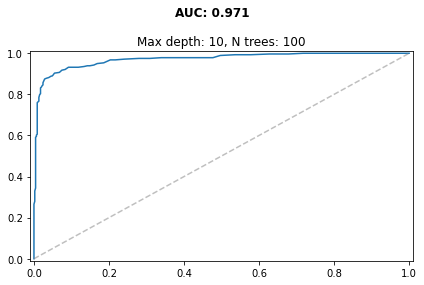

In [ ]:
y_pred = best_model.predict(X_validation)

plot_roc(y_validation.to_numpy(), y_pred, title=f"Max depth: {best_model.max_depth}, N trees: {best_model.n_estimators}")

# Задание 3 (3 балла)

Часто хочется понимать, насколько большую роль играет тот или иной признак для предсказания класса объекта. Есть различные способы посчитать его важность. Один из простых способов сделать это для Random Forest выглядит так:
1. Посчитать out-of-bag ошибку предсказания `err_oob` (https://en.wikipedia.org/wiki/Out-of-bag_error)
2. Перемешать значения признака `j` у объектов выборки (у каждого из объектов изменится значение признака `j` на какой-то другой)
3. Посчитать out-of-bag ошибку (`err_oob_j`) еще раз.
4. Оценкой важности признака `j` для одного дерева будет разность `err_oob_j - err_oob`, важность для всего леса считается как среднее значение важности по деревьям.

Реализуйте функцию `feature_importance`, которая принимает на вход Random Forest и возвращает массив, в котором содержится важность для каждого признака.

In [ ]:
def oob_error(rfc, X, y):
    
    out_of_bag_errors = []
    
    for tree in rfc.estimators:
        used_indexes = tree.X_indexes
        
        not_used_samples = X.loc[~X.index.isin(used_indexes)]
        
        y_true = y.loc[~X.index.isin(used_indexes)].to_numpy().flatten()
        
        if not_used_samples.shape[0]:  # There are not used samples
            y_pred_oob = rfc.predict(not_used_samples)
            error = 1 - np.mean(y_true == y_pred_oob)
            
        else:
            error = 0  # All samples are used in the bootstrapping, so we can't calculate OOB error

        out_of_bag_errors.append(error)
        
    return np.mean(out_of_bag_errors)


def feature_importance(rfc, X, y):
    
    out_of_bag_error = oob_error(rfc, X, y)

    feature_importances = []
        
    for feature in X.columns:
        old_values = X[feature].to_numpy()
        
        # Shuffle values of feature
        feature_values = old_values.copy()
        np.random.shuffle(feature_values)
        X[feature] = feature_values

        # Calculate error without the feature
        importance = oob_error(rfc, X, y) - out_of_bag_error
        feature_importances.append(importance)
                 
        # Return original values to the dataframe
        X[feature] = old_values
        
    return np.array(feature_importances)
    

def most_important_features(importance, names, k=20):
    # Выводит названия k самых важных признаков
    features_indexes = np.argsort(importance)[::-1][:k]
    return np.array(names)[features_indexes]

Протестируйте решение на простом синтетическом наборе данных. В результате должна получиться точность `1.0`, наибольшее значение важности должно быть у признака с индексом `4`, признаки с индексами `2` и `3`  должны быть одинаково важны, а остальные признаки - не важны совсем.

In [ ]:
def synthetic_dataset(size):
    X = [(np.random.randint(0, 2), np.random.randint(0, 2), i % 6 == 3, 
          i % 6 == 0, i % 3 == 2, np.random.randint(0, 2)) for i in range(size)]
    y = [i % 3 for i in range(size)]
    return pd.DataFrame(X), pd.DataFrame(y)

X, y = synthetic_dataset(1000)
rfc = RandomForestClassifier(n_estimators=15, max_features=6, store_indexes=True)
rfc.fit(X, y)

y_pred = rfc.predict(X)

print("Accuracy:", np.mean(y_pred == y.to_numpy().flatten()))
print("Importance:", feature_importance(rfc, X, y))

Accuracy: 1.0
Importance: [0.         0.         0.20648837 0.20589866 0.46676227 0.        ]


Проверьте, какие признаки важны для датасета spam? (Используйте файлы x_spam_train и y_spam_train)

In [ ]:
model = RandomForestClassifier(n_estimators=20, max_depth=5, store_indexes=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)

print("Accuracy:", np.mean(y_pred == y_train.to_numpy().flatten()))

Accuracy: 0.8661684782608695


In [ ]:
importances = feature_importance(model, X_train, y_train)

<BarContainer object of 57 artists>

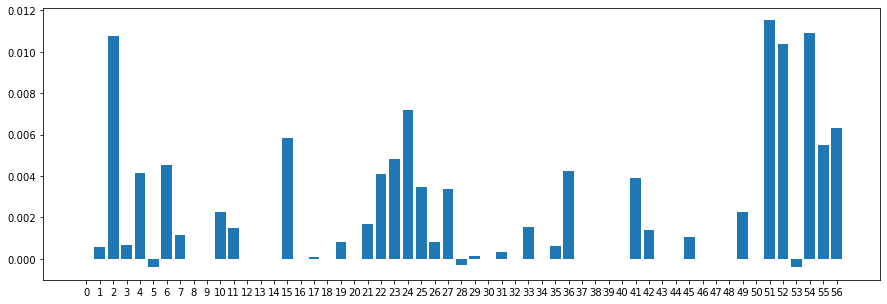

In [ ]:
plt.figure(figsize=(15, 5))
plt.bar(X_train.columns, importances)

In [ ]:
most_important_features(importances, X_train.columns)

array(['51', '54', '2', '52', '24', '56', '15', '55', '23', '6', '36',
       '4', '22', '41', '25', '27', '49', '10', '21', '33'], dtype=object)

1. Обучите модель на всех данных из x_spam_train и y_spam_train.
2. Сделайте submit своего решения и получите значение f1_score не менее 0.6

In [ ]:
X = pd.read_csv("data/x_spam_train.csv", index_col=0)
y = pd.read_csv("data/y_spam_train.csv", index_col=0)

model = RandomForestClassifier(max_depth=depth, n_estimators=max_trees)
model.fit(X, y)

In [ ]:
submission = pd.DataFrame(columns = ["Id", "Expected"])
submission["Id"] = test["Id"]
submission["Expected"] = model.predict(y)
submission.to_csv('submission.csv', index=False)

# Задание 4 (2 балла)

В качестве альтернативы попробуем библиотечные реализации ансамблей моделей. 

1. [CatBoost](https://catboost.ai/docs/)
2. [XGBoost](https://xgboost.readthedocs.io/en/latest/)
3. [LightGBM](https://lightgbm.readthedocs.io/en/latest/)


Установите необходимые библиотеки. 
Возможно, потребуется установка дополнительных пакетов.

1. Примените модели для нашего датасета.

2. Для стандартного набора параметров у каждой модели нарисуйте `ROC` кривую и выведите `AUC` и `accuracy`.

3. Посчитайте время обучения каждой модели (можно использовать [timeit magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit)).

4. Сравните метрики качества и скорость обучения моделей. Какие выводы можно сделать?

In [ ]:
import lightgbm
import catboost
import xgboost

In [ ]:
X = pd.read_csv("data/x_spam_train.csv", index_col=0)
y = pd.read_csv("data/y_spam_train.csv", index_col=0)
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2)

In [ ]:
def build_and_evaluate_model(X_train, y_train, X_validation, y_validation, model):
    model.fit(X_train, y_train.to_numpy().flatten())

    accuracy = np.mean(y_validation.to_numpy().flatten() == model.predict(X_validation))

    print("Accuracy:", round(accuracy, 4))

    plot_roc(y_validation.to_numpy(), model.predict_proba(X_validation)[:, 1], title=str(model))

Accuracy: 0.9511


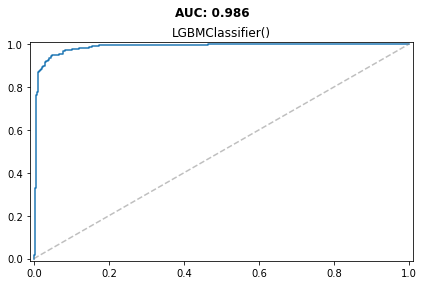

In [ ]:
build_and_evaluate_model(X_train, y_train, X_validation, y_validation, model=lightgbm.LGBMClassifier())

Accuracy: 0.9497


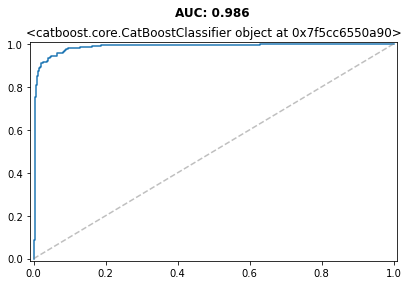

In [ ]:
build_and_evaluate_model(X_train, y_train, X_validation, y_validation, model=catboost.CatBoostClassifier(silent=True))

Accuracy: 0.9348


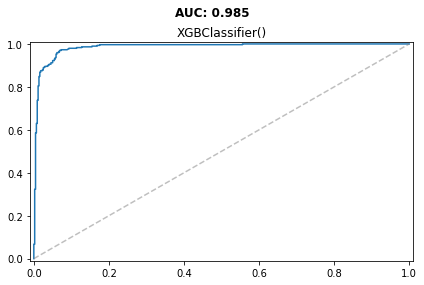

In [ ]:
build_and_evaluate_model(X_train, y_train, X_validation, y_validation, model=xgboost.XGBClassifier())

У всех моделей сравнимое качество. Время обучения было следующим:

* lightGBM: **800 ms**
* CatBoost: **12.5 s**
* XGBoost: **826 ms**

CatBoost оказался значительно медленнее других моделей, а lightGBM – самым быстрым. Видимо, если категориальных признаков в данных нет, лучше всего использовать lightGBM